## Programming Exercise 4: Neural Networks Learning
#### Author - Rishabh Jain

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

#### Learning Resources

1. [What is a Neural Network??](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
2. [Gradient Descent, how neural networks learn?](https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2)
3. [What is Backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3)
4. [Backpropagation Calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=4)

### 1&nbsp;&nbsp;&nbsp;&nbsp;Neural Networks

##### Problem Statement
In the previous exercise, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the provided weights. **In this exercise, we will implement the backpropagation algorithm to learn the parameters for the neural network.**

We will use the same dataset that we used in the previous exercise. There are 5000 training examples, where each example is 20 X 20 pixel image of a handwritten digit. Each pixel is represented by a floating point number indicating the graysacle intensity at that location. This 20 by 20 grid of pixels is 'unrolled' into a 400 dimensional vector.

In [2]:
# Loading Mat file
mat=loadmat('./ex4data1.mat')
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y


In [3]:
# Loading data from mat to Dataframe
m,n=mat['X'].shape

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'].T[i]

# Converting label 10 to label 0
data['y']=mat['y']
data.loc[data['y']==10,'y']=0

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

TRAINING DATASET SHAPE : 5000 X 401


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x392,x393,x394,x395,x396,x397,x398,x399,x400,y
2818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,5
3484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,6
2145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,4
3718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,7
903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.011034,0.134067,0.447564,0.066053,-0.0106,0.0,0.0,0.0,0.0,1


#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the data

We will begin by visualizing a subset of the training set. We will randomly select 100 rows from X. This function maps each row to a 20 X 20 pixel image and displays together.

In [4]:
def displayData(X):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))
    colPadding=np.ones((height,1))
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray,cmap='gray')
    plt.axis('off')

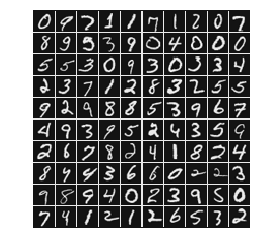

In [5]:
displayData(data.sample(100).iloc[:,:-1].values)

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Model Representation

<table>
    <tr>
        <td>
            <img src="https://cdn-images-1.medium.com/max/1200/1*uyIJXyLOI4-ETDmcWFsKvQ.png" width="300">
        </td>
        <td>
            <img src="http://ufldl.stanford.edu/tutorial/images/Network331.png" width="300">
        </td>
    </tr>
</table>

$a_i^{(j)}=$ "activation" of unit $i$ in layer $j$  
$\theta^{(j)}=$ matrix of weights controlling function mapping from layer $j$ to layer $j+1$  
$g(x)=$ sigmoid activation function  

**If network has $s_j$ units in layer $j$, $s_{j+1}$ units in layer $j+1$, then $\theta^{(j)}$ will be of dimension $s_{j+1}$ X $(s_j+1)$**


$$ a^{(2)}_1=g(\theta_{10}^{(1)}x_0+\theta_{11}^{(1)}x_1+\theta_{12}^{(1)}x_2+\theta_{13}^{(1)}x_3) $$

$$ a^{(2)}_2=g(\theta_{20}^{(1)}x_0+\theta_{21}^{(1)}x_1+\theta_{22}^{(1)}x_2+\theta_{23}^{(1)}x_3) $$

$$ a^{(2)}_3=g(\theta_{30}^{(1)}x_0+\theta_{31}^{(1)}x_1+\theta_{32}^{(1)}x_2+\theta_{33}^{(1)}x_3) $$


In this exercise, we will be using the parameters from a neural network that is already trained. Our goal is to implement the **Feed-Forward Progration** algorithm for prediction.

In [6]:
# Loading weights
weights=loadmat('./ex4weights.mat')
print(*weights.keys(),sep='\n')

__header__
__version__
__globals__
Theta1
Theta2


The neural network we are about to use has 3 layers - an input layer ($L_1$), a hidden layer ($L_2$) and an output layer ($L_3$). 

* L1 layer has 400 Neuron units (20 X 20 pixel image) excluding the extra bias unit that always output +1
* L2 layer has 25 Neuron units
* L3 layer has 10 Neuron Units

In [7]:
theta1=weights['Theta1']
theta2=weights['Theta2']
print(f'Theta1 : {theta1.shape}')
print(f'Theta2 : {theta2.shape}')

Theta1 : (25, 401)
Theta2 : (10, 26)


#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Feedforward and cost function

In [8]:
def sigmoid(z):
    sigma=1/(1+np.exp(-z))
    return sigma

**Feed Forward**  
Step 0 : $a^{(1)}=x$  
Step 1 : $z^{(2)}=\theta^{(1)}a^{(1)}$  
Step 2 : $a^{(2)}=g(z^{(2)})$  
Step 3 : Add $a^{(2)}_0=1$  
Step 4 : $z^{(3)}=\theta^{(2)}a^{(2)}$  
Step 5 : $a^{(3)}=g(z^{(3)})$  
Step 6 : $h_\theta(x)=a^{(3)}$

In [9]:
def predictNN(theta1,theta2,X):
    '''Predict the label of an input given a trained neural network'''
    m,n=X.shape
    # Feed Forward Propogation
    a1=X
    z2=np.dot(a1,theta1.T)
    a2=sigmoid(z2)
    a2=np.column_stack((np.ones(shape=(a2.shape[0],1)),a2))
    z3=np.dot(a2,theta2.T)
    a3=sigmoid(z3)
    h=a3
    return h

**Cost function** for a Neural Network is very similar to logistic regression except that the cost is summed over all the K classes.

$$ J(\theta)=\frac{-1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[y_k^{(i)}log(h_\theta(x^{(i)})_k)+(1-y_k^{(i)})log(1-h_\theta(x^{(i)})_k)] $$ 

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;Regularized cost function

We should not be regularizing the terms that corresponds to the bias term. For the matrices $\theta^{(1)}$ and $\theta^{(2)}$, this corresponds to the first column of each matrix. The cost function for neural networks with regularization is given by:

$$ J(\theta)=\frac{-1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[y_k^{(i)}log(h_\theta(x^{(i)})_k)+(1-y_k^{(i)})log(1-h_\theta(x^{(i)})_k)] + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_{l}}\sum_{j=1}^{s_{l}+1}(\theta_{ij^{(l)}})^2$$ 



In [10]:
def computeCost(thetas,inputLayerSize,hiddenLayerSize,X,y,lmbda):
    '''Computes the cost using Cross Entropy function'''
    labels=len(np.unique(y))
    theta1=thetas[:,0:hiddenLayerSize*(inputLayerSize+1)].reshape((hiddenLayerSize,inputLayerSize+1))
    theta2=thetas[:,hiddenLayerSize*(inputLayerSize+1):].reshape((labels,hiddenLayerSize+1))
    m,n=X.shape
    # FeedForward Propogation
    h=predictNN(theta1,theta2,X)
    # One hot encoding of target variable
    y=pd.get_dummies(y.reshape(m)).values
    # Computing cost
    J=(-1/m)*np.sum(np.multiply(y,np.log(h))+np.multiply(1-y,np.log(1-h)))
    # Adding regularization term
    J=J+(lmbda/(2*m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))
    return J

In [11]:
X=mat['X']
X=np.column_stack((np.ones(m),X))
y=mat['y']

# Unrolling parameters matrices into one single vector
thetas=theta1.reshape((1,-1))
thetas=np.column_stack((thetas,theta2.reshape((1,-1))))

inputLayerSize=400
hiddenLayerSize=25

In [12]:
lmbda=0
J=computeCost(thetas,inputLayerSize,hiddenLayerSize,X,y,lmbda)
print(f'COST FUNCTION : {J:.4f}')

COST FUNCTION : 0.2876


In [14]:
lmbda=1
J=computeCost(thetas,inputLayerSize,hiddenLayerSize,X,y,lmbda)
print(f'COST FUNCTION (with regularization): {J:.4f}')

COST FUNCTION (with regularization): 0.3838


### 2&nbsp;&nbsp;&nbsp;&nbsp;Backpropagation

In this part of the exercise , we will implement the **backpropagation algorithm to compute the gradient for the neural network cost function.** Once we have computed the gradient, we will be able to train the neural network by minimizing the cost function $J(\theta)$ using gradient descent.

**Let's try to understand the mathematical derivation of the backpropagation algorithm :** 

Given an input $X$, output $h_{\theta}(x)$ is determined by $\theta^{(1)}$, $\theta^{(2)}$, $\theta^{(3)}$ ... $\theta^{(n)}$. To reduce the error $J(\theta)$ we have to change the weights $\theta_i$ using gradient descent update rule.

$$ \theta^{(l)}=\theta^{(l)}-\alpha\frac{\partial{J}}{\partial{\theta^{(l)}}} $$

<img src="http://ufldl.stanford.edu/tutorial/images/Network3322.png" width="400">

For a neural network, we can say that the **change in $J(\theta)$ $w.r.t$ $\theta$ results from a change in $z$ (sum of the product of input and parameter) which in turn changes $a$ (activation) which eventually changes $J$**. This relationship for an above neural network can be written in calculus like this :

$ \frac{\partial{J}}{\partial{\theta^{(3)}}} = \frac{\partial{J}}{\partial{a^{(4)}}}\frac{\partial{a^{(4)}}}{\partial{z^{(4)}}}\frac{\partial{z^{(4)}}}{\partial{\theta^{(3)}}} $  

Replacing $\frac{\partial{J}}{\partial{a^{(4)}}}=(a^{(4)}-y)$ and $z^{(4)}$ and $a^{(4)}$ using feed forward expressions, we get

$ \;\;\;\;\;\;\;=(a^{(4)}-y)\frac{\partial{g(z^{(4)})}}{\partial{z^{(4)}}}\frac{\partial{(\theta^{(3)}a^{(3)}})}{\partial{\theta^{(3)}}} $

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})a^{(3)} $

$ \boxed{\frac{\partial{J}}{\partial{\theta^{(3)}}} =\delta^{(4)}a^{(3)}} \;\;\;\;\;\;\;$ where,  $\boxed{\delta^{(4)}=(a^{(4)}-y)g'(z^{(4)})} $

Similarly, computing

$ \frac{\partial{J}}{\partial{\theta^{(2)}}} = \frac{\partial{J}}{\partial{a^{(4)}}}\frac{\partial{a^{(4)}}}{\partial{z^{(4)}}}\frac{\partial{z^{(4)}}}{\partial{a^{(3)}}}\frac{\partial{a^{(3)}}}{\partial{z^{(3)}}}\frac{\partial{z^{(3)}}}{\partial{\theta^{(2)}}} $  

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\frac{\partial{(\theta^{(3)}a^{(3)}})}{\partial{a^{(3)}}}\frac{\partial{g(z^{(3)})}}{\partial{z^{(3)}}}\frac{\partial{(\theta^{(2)}a^{(2)}})}{\partial{\theta^{(2)}}} $

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\theta^{(3)}g'(z^{(3)})a^{(2)} $

$ \;\;\;\;\;\;\;=\delta^{(4)}\theta^{(3)}g'(z^{(3)})a^{(2)} $

$ \boxed{\frac{\partial{J}}{\partial{\theta^{(2)}}} =\delta^{(3)}a^{(2)}} \;\;\;\;\;\;\;$ where,  $\boxed{\delta^{(3)}=\theta^{(3)}\delta^{(4)}g'(z^{(3)})} $

Similarly, computing for 

$ \frac{\partial{J}}{\partial{\theta^{(1)}}} = \frac{\partial{J}}{\partial{a^{(4)}}}\frac{\partial{a^{(4)}}}{\partial{z^{(4)}}}\frac{\partial{z^{(4)}}}{\partial{a^{(3)}}}\frac{\partial{a^{(3)}}}{\partial{z^{(3)}}}\frac{\partial{z^{(3)}}}{\partial{a^{(2)}}}\frac{\partial{a^{(2)}}}{\partial{z^{(2)}}}\frac{\partial{z^{(2)}}}{\partial{\theta^{(1)}}} $  

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\theta^{(3)}g'(z^{(3)})\frac{\partial{(\theta^{(2)}a^{(2)}})}{\partial{a^{(2)}}}\frac{\partial{g(z^{(2)})}}{\partial{z^{(2)}}}\frac{\partial{(\theta^{(1)}a^{(1)})}}{\partial{\theta^{(1)}}} $

$ \;\;\;\;\;\;\;=(a^{(4)}-y)g'(z^{(4)})\theta^{(3)}g'(z^{(3)})\theta^{(2)}g'(z^{(2)})a^{(1)} $

$ \;\;\;\;\;\;\;=\delta^{(4)}\theta^{(3)}g'(z^{(3)})\theta^{(2)}g'(z^{(2)})a^{(1)} $

$ \;\;\;\;\;\;\;=\delta^{(3)}\theta^{(2)}g'(z^{(2)})a^{(1)} $

$ \boxed{\frac{\partial{J}}{\partial{\theta^{(1)}}} =\delta^{(2)}a^{(1)}} \;\;\;\;\;\;\;$ where,  $\boxed{\delta^{(2)}=\theta^{(2)}\delta^{(3)}g'(z^{(2)})} $